**кластеризатор DBSCAN**


Евгений Борисов esborisov@sevsu.ru

---

In [1]:
import numpy as np
from numpy import random as rng
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances

In [2]:
from sklearn.datasets import make_blobs

In [3]:
n_samples = 500
n_clst = 5 # количество кластеров

X,_ = make_blobs( 
        n_samples=n_samples,
        centers=n_clst,  
        cluster_std=rng.uniform(size=n_clst)+.7
    )
X.shape

(500, 2)

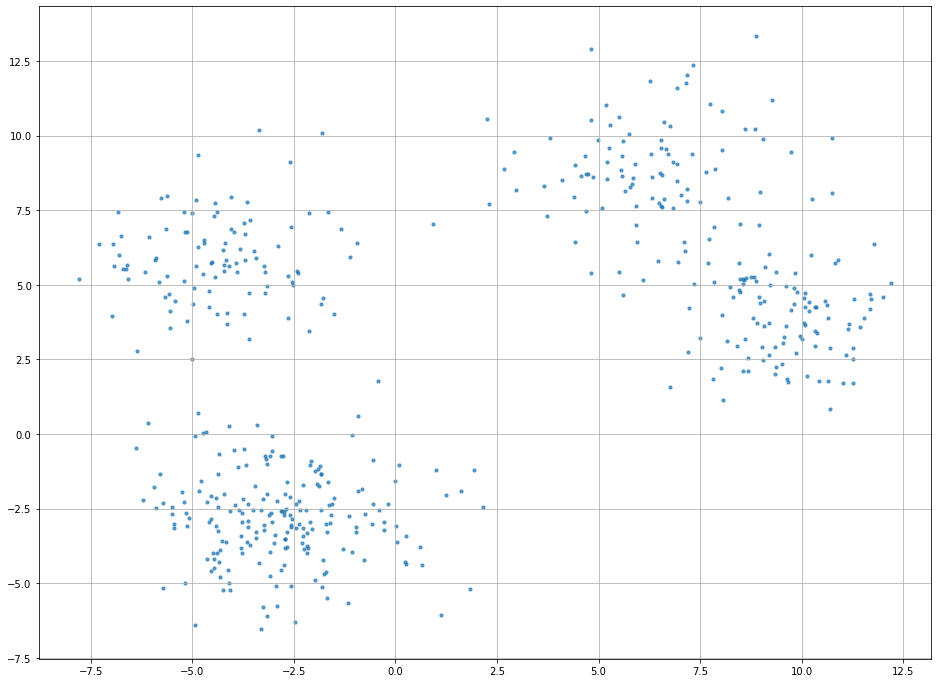

In [4]:
plt.figure(figsize=(16,12))
plt.scatter( x=X[:,0], y=X[:,1], s=10, alpha=0.7 )
plt.grid()
plt.show()

---

In [5]:
def neighbor(X,ic,min_radius): 
    d = euclidean_distances([X[ic]],X).flatten()
    return set(np.where(d<min_radius)[0])


def build_subcluster(X, candidates, free_points, noize, min_radius, min_size):
    # для всех точек candidates собираем окрестности из свободных или шумовых точек кластера
    neighbor_candidates = { i:neighbor(X,i,min_radius) & (free_points|noize)  for i in candidates }
    # у точек много соседей - корневые
    root = set([ i for i,v in neighbor_candidates.items() if len(v)+1>min_size ])
    # соседи корневых
    root_neighbor = [ v for i,v in neighbor_candidates.items() if len(v)+1>min_size ]
    root_neighbor = set.union(*root_neighbor)-root
    
    # у точек мало соседей - граничные
    boundary = set([ i for i,v in neighbor_candidates.items() if len(v)<min_size ])
    return root, root_neighbor, boundary



def build_cluster(X, free_points, clusters, noize, min_radius, min_size):
    if len(free_points)<1: # если необработаных не осталось  
        return clusters,noize # то выдаём результат
    
    # выбираем случайную необработанную точку ...
    ic = rng.choice(np.array(list(free_points)))
   
    # .. и собираем её свободных или шумовых соседей
    neighbor_index = neighbor(X,ic,min_radius) & (free_points|noize) 
    
    # если количество соседей меньше порога ...
    if len(neighbor_index)< min_size:
        noize |= neighbor_index # ... то помечаем соседей как шумовые
        free_points -= noize # ... и удаляем шумовые точки из необработанных
    else: # иначе повторить сбор соседей для всех отобранных точек
        root, root_neighbor, boundary = build_subcluster(
            X, 
            neighbor_index, 
            free_points, 
            noize, 
            min_radius, 
            min_size
        )
        clusters.append( { 'root':root,'neighbor':root_neighbor,'boundary':boundary, } )
        noize -= root|root_neighbor|boundary
        free_points -= root|root_neighbor|boundary|noize
                    
    # повторить для необработанных     
    return build_cluster(
        X=X, 
        free_points=free_points, 
        clusters=clusters, 
        noize=noize, 
        min_radius=min_radius, 
        min_size=min_size,
    )   
        
        
def dbscan(X, min_radius, min_size):
    return build_cluster(
        X=X, 
        free_points = set(range(len(X))), 
        clusters=[], 
        noize=set(), 
        min_radius=min_radius, 
        min_size=min_size,
    )

In [6]:
np.median(euclidean_distances(X))

10.061674025245136

In [7]:
# выполяем кластеризацию
clusters,noize = dbscan(
    X, 
    min_radius=2.1, 
    min_size=7
)

In [8]:
# разбираем точки на группы 

X_boundary = []
X_neighbor = []
X_root = []

X_boundary_label = []
X_neighbor_label = []
X_root_label = []
X_clusters = []

for i,c in enumerate(clusters):
    X_c = []
    if len(c['boundary'])>0:
        X_boundary.append( X[np.array(list(c['boundary']))] )
        X_boundary_label.extend( [i]*len(c['boundary']) )
        X_c.append(X[np.array(list(c['boundary']))])
        
    if len(c['neighbor'])>0:
        X_neighbor.append( X[np.array(list(c['neighbor']))] )
        X_neighbor_label.extend( [i]*len(c['neighbor']) )
        X_c.append(X[np.array(list(c['neighbor']))])
        

    if len(c['root'])>0:
        X_root.append( X[np.array(list(c['root']))] )
        X_root_label.extend( [i]*len(c['root']) )
        X_c.append(X[np.array(list(c['root']))])
        
    X_clusters.append(np.vstack(X_c))
        
if len(noize)>0:
    X_noize = X[np.array(list(noize))]
    
X_boundary = [] if len(X_boundary)==0 else np.vstack(X_boundary)
X_neighbor = [] if len(X_neighbor)==0 else np.vstack(X_neighbor)
X_root = [] if len(X_root)==0 else np.vstack(X_root)

In [9]:
from scipy.spatial import ConvexHull

def hull(x):
    hull = ConvexHull(x) # рисуем выпуклую оболочку вокруг кластера
    v = np.append( hull.vertices, hull.vertices[0] ) # замыкаем оболочку
    plt.plot(x[v,0],x[v,1],'--',lw=1,c='b')

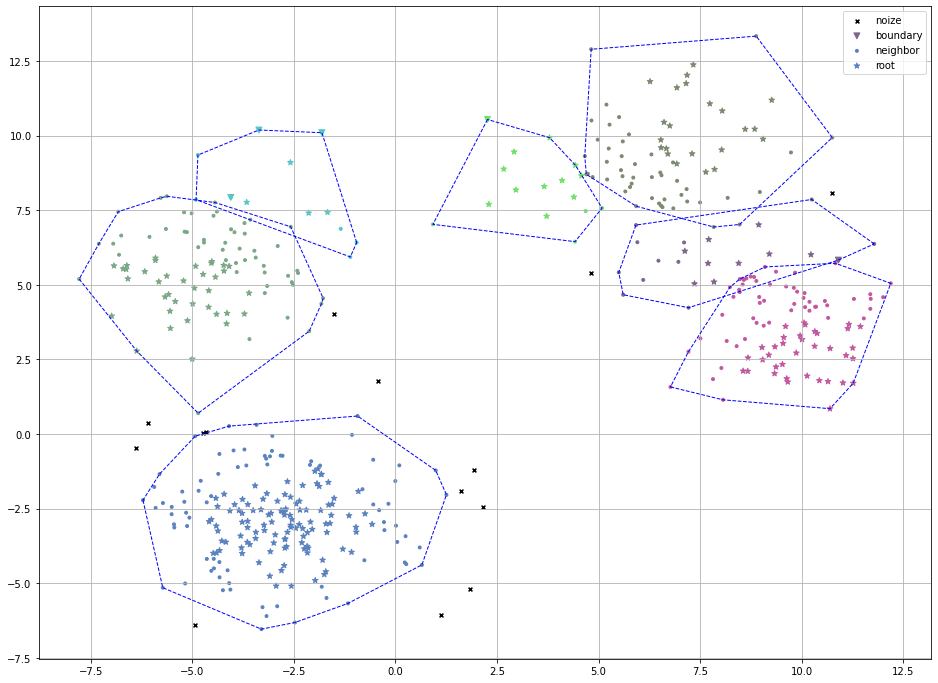

In [10]:
colors = rng.uniform(size=(len(clusters),3),low=.3,high=1.)

fig = plt.figure(figsize=(16,12))

if len(noize)>0:
    plt.scatter( x=X_noize[:,0],y=X_noize[:,1], s=15, marker='x',c='black', label='noize' )
    
if len(X_boundary)>0:
    plt.scatter(x=X_boundary[:,0],y=X_boundary[:,1],s=35,marker='v',c=colors[X_boundary_label],label='boundary')

if len(X_neighbor)>0:
    plt.scatter(x=X_neighbor[:,0],y=X_neighbor[:,1],s=35,marker='.',c=colors[X_neighbor_label],label='neighbor')

if len(X_root)>0:
    plt.scatter(x=X_root[:,0],y=X_root[:,1],s=35,marker='*',c=colors[X_root_label],label='root')
    
for i,_ in enumerate(clusters): hull(X_clusters[i])

plt.legend()
plt.grid() 